# Prediction

In [12]:
import pandas as pd
import geopandas as gpd
import shapefile
import folium
import operator
from sklearn.linear_model import LinearRegression  
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Data Proprecessing

## Rent Data

In [13]:
post = pd.read_csv("../data/raw/postcode_info.csv")
df = pd.DataFrame()

In [14]:
rent_data = pd.read_excel("https://www.dffh.vic.gov.au/sites/default/files/documents/202209/Moving%20annual%20rent%20by%20suburb%20-%20June%20quarter%202022.xlsx", sheet_name='All properties')
rent = rent_data.drop(index= list(rent_data[rent_data['Unnamed: 1'] == 'Group Total'].index))
rent_data = rent_data.loc[2:]
rent_data.drop(['Moving annual median rent by suburb'],axis=1,inplace=True)
rent_data = rent_data.loc[:,::2]
rent_data.rename(columns={'Unnamed: 1':'suburb'}, inplace = True)
rent_data.head()

,suburb,Unnamed: 3,Unnamed: 5,Unnamed: 7,Unnamed: 9,Unnamed: 11,Unnamed: 13,Unnamed: 15,Unnamed: 17,Unnamed: 19,...,Unnamed: 163,Unnamed: 165,Unnamed: 167,Unnamed: 169,Unnamed: 171,Unnamed: 173,Unnamed: 175,Unnamed: 177,Unnamed: 179,Unnamed: 181
2,Albert Park-Middle Park-West St Kilda,260,260,270,275,275,280,280,290,300,...,600,580,550,550,500,500,500,495,500,520
3,Armadale,200,200,205,210,215,220,225,230,233,...,500,500,500,495,450,440,425,420,430,450
4,Carlton North,260,260,265,270,270,275,280,280,290,...,585,590,590,590,580,575,575,580,580,595
5,Carlton-Parkville,260,260,260,260,260,260,265,270,270,...,404,400,400,395,350,340,330,320,310,319
6,CBD-St Kilda Rd,320,320,320,320,320,320,320,320,320,...,510,495,460,420,380,369,350,350,364,390


In [15]:
#Preprocess suburb
data_suburb = pd.DataFrame()
sublist = []
for i in rent_data["suburb"]:
    index = rent_data[rent_data.suburb == i].index.tolist()[0]
    if operator.contains(i, "-"):
        j = i.split("-")
        for sub in j:
            sublist.append(sub)
            series = pd.DataFrame(rent_data[index-2:index-1])
            data_suburb = pd.concat([data_suburb, series])
    else:
        sublist.append(i)
        series = pd.DataFrame(rent_data[index-2:index-1])
        data_suburb = pd.concat([data_suburb, series])

data_suburb.insert(0, "suburb new", sublist)
data_suburb.drop(data_suburb.columns[1:2],axis=1,inplace=True)
name = ['suburb']
for i in list(range(2,181,2)):
    name.append(rent[rent.columns.values.tolist()[i]][:1].tolist()[0])
data_suburb.columns = name
data_suburb['postcode'] = ''
df = data_suburb.reset_index(drop=True)

In [16]:
#remove group total
for i in range(len(df)):
    if post[(post['Locality'] == str.upper(df['suburb'][i]))]['Postcode'].to_list() == []:
        df.loc[i,'postcode'] = 0
    else:
        df.loc[i,'postcode'] = post[(post['Locality'] == str.upper(df['suburb'][i])) & (post['State'] == 'VIC')]['Postcode'].to_list()[0]
df=df.drop(df[df['suburb'] == 'Group Total'].index)

In [17]:
#check which suburb cannot be Identified
df[df['postcode'] == 0]

,suburb,Mar 2000,Jun 2000,Sep 2000,Dec 2000,Mar 2001,Jun 2001,Sep 2001,Dec 2001,Mar 2002,...,Jun 2020,Sep 2020,Dec 2020,Mar 2021,Jun 2021,Sep 2021,Dec 2021,Mar 2022,Jun 2022,postcode
2,West St Kilda,260,260,270,275,275,280,280,290,300,...,580,550,550,500,500,500,495,500,520,0
7,CBD,320,320,320,320,320,320,320,320,320,...,495,460,420,380,369,350,350,364,390,0
8,St Kilda Rd,320,320,320,320,320,320,320,320,320,...,495,460,420,380,369,350,350,364,390,0
13,East St Kilda,180,180,180,180,185,190,195,195,200,...,425,420,410,395,385,380,380,380,390,0
51,East Hawthorn,200,201,210,215,220,230,235,235,230,...,440,438,420,400,400,390,380,390,400,0
107,East Brunswick,190,210,210,230,230,240,240,240,250,...,450,450,425,420,410,400,400,400,420,0
120,West Brunswick,140,141,145,150,150,153,160,165,170,...,400,390,380,380,360,350,350,350,360,0
153,Yarra Ranges,150,150,155,155,160,160,165,165,165,...,400,400,400,400,415,420,425,435,450,0
171,Mt Eliza,170,175,180,180,185,190,190,195,200,...,485,496,508,520,545,550,570,590,600,0
173,Mt Martha,170,175,180,180,185,190,190,195,200,...,485,496,508,520,545,550,570,590,600,0


In [18]:
#look up suburb from google
df.loc[2,'postcode'] = 3182
df.loc[7,'postcode'] = 3000
df.loc[8,'postcode'] = 3004
df.loc[13,'postcode'] = 3183
df.loc[51,'postcode'] = 3123
df.loc[107,'postcode'] = 3057
df.loc[120,'postcode'] = 3055
df.loc[153,'postcode'] = 3160
df.loc[171,'postcode'] = 3930
df.loc[173,'postcode'] = 3934
df.loc[181,'postcode'] = 3219
df.loc[198,'postcode'] = 3550
df.loc[223,'postcode'] = 3677

In [19]:
df_past = df.drop(df.columns[1:57], axis=1)
for i in range(1, len(df_past.columns)-2, 4):
    df_past[df_past.columns[i][-4:]] = df_past[[df_past.columns[i], df_past.columns[i+1], df_past.columns[i+2], df_past.columns[i+3]]].mean(axis=1)
    if i  == 33:
        df_past[df_past.columns[i][-4:]] = df_past[[df_past.columns[i], df_past.columns[i+1]]].mean(axis=1)
df_past.head()

,suburb,Mar 2014,Jun 2014,Sep 2014,Dec 2014,Mar 2015,Jun 2015,Sep 2015,Dec 2015,Mar 2016,...,postcode,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Albert Park,460,470,480,480,480,495,495,500,520,...,3206,472.50,492.50,515.0,527.75,562.50,569.25,570.00,498.75,510.0
1,Middle Park,460,470,480,480,480,495,495,500,520,...,3206,472.50,492.50,515.0,527.75,562.50,569.25,570.00,498.75,510.0
2,West St Kilda,460,470,480,480,480,495,495,500,520,...,3182,472.50,492.50,515.0,527.75,562.50,569.25,570.00,498.75,510.0
3,Armadale,390,395,390,400,400,399,400,400,400,...,3143,393.75,399.75,402.5,445.00,487.50,481.25,498.75,433.75,440.0
4,Carlton North,510,510,520,520,530,530,530,530,530,...,3054,515.00,530.00,527.5,545.00,566.25,579.25,588.75,577.50,587.5


In [20]:
#get the rent price from 2014-2022
rent_past = df_past.drop(df_past.columns[1:35], axis=1)
rent_past.head()

,suburb,postcode,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Albert Park,3206,472.50,492.50,515.0,527.75,562.50,569.25,570.00,498.75,510.0
1,Middle Park,3206,472.50,492.50,515.0,527.75,562.50,569.25,570.00,498.75,510.0
2,West St Kilda,3182,472.50,492.50,515.0,527.75,562.50,569.25,570.00,498.75,510.0
3,Armadale,3143,393.75,399.75,402.5,445.00,487.50,481.25,498.75,433.75,440.0
4,Carlton North,3054,515.00,530.00,527.5,545.00,566.25,579.25,588.75,577.50,587.5


## Population & Income

### We use the population density and weekly income as features

In [21]:
pop = pd.read_csv("../data/curated/population_postcode.csv", index_col=0)
income = pd.read_csv("../data/curated/VIC_weekly_income_poa.csv", index_col=0)

In [22]:
# get the past income
income_past = income.drop(list(income.columns)[1:2],axis=1)
income_past = income_past.drop(list(income.columns)[11:],axis=1)
income_past = income_past.rename(columns={'Postcode':'postcode'})
income_past

,postcode,Median weekly income in 2014,Median weekly income in 2015,Median weekly income in 2016,Median weekly income in 2017,Median weekly income in 2018,Median weekly income in 2019,Median weekly income in 2020,Median weekly income in 2021,Median weekly income in 2022
0,3000,628.79,600.81,539.77,553.96,577.38,566.20,555.22,544.46,533.91
1,3001,628.79,600.81,539.77,553.96,577.38,566.20,555.22,544.46,533.91
2,8001,628.79,600.81,539.77,553.96,577.38,566.20,555.22,544.46,533.91
3,8003,628.79,600.81,539.77,553.96,577.38,566.20,555.22,544.46,533.91
4,8006,628.79,600.81,539.77,553.96,577.38,566.20,555.22,544.46,533.91
...,...,...,...,...,...,...,...,...,...,...
711,3991,698.38,695.37,701.85,731.92,767.00,785.36,804.17,823.42,843.14
712,3992,698.38,695.37,701.85,731.92,767.00,785.36,804.17,823.42,843.14
713,3995,698.38,695.37,701.85,731.92,767.00,785.36,804.17,823.42,843.14
714,3996,698.38,695.37,701.85,731.92,767.00,785.36,804.17,823.42,843.14


In [23]:
result = pd.merge(rent_past, income_past, how='left', on=['postcode'])
result

,suburb,postcode,2014,2015,2016,2017,2018,2019,2020,2021,2022,Median weekly income in 2014,Median weekly income in 2015,Median weekly income in 2016,Median weekly income in 2017,Median weekly income in 2018,Median weekly income in 2019,Median weekly income in 2020,Median weekly income in 2021,Median weekly income in 2022
0,Albert Park,3206,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0,1249.52,1300.52,1272.31,1281.29,1298.42,1311.26,1324.23,1337.32,1350.55
1,Middle Park,3206,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0,1249.52,1300.52,1272.31,1281.29,1298.42,1311.26,1324.23,1337.32,1350.55
2,West St Kilda,3182,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0,1012.58,1030.04,1020.50,1095.00,1146.58,1183.29,1221.19,1260.29,1300.65
3,Armadale,3143,393.75,399.75,402.50,445.00,487.50,481.25,498.75,433.75,440.0,1194.02,1234.02,1232.21,1271.12,1337.75,1376.55,1416.49,1457.57,1499.85
4,Carlton North,3054,515.00,530.00,527.50,545.00,566.25,579.25,588.75,577.50,587.5,1032.40,1046.38,1055.31,1100.77,1156.08,1189.43,1223.74,1259.04,1295.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,Traralgon,3844,263.75,270.00,270.00,276.25,278.75,287.50,307.50,345.00,370.0,718.02,699.37,680.54,730.83,716.00,716.13,716.25,716.38,716.51
211,Wanagaratta,3677,247.50,250.00,260.00,266.25,274.25,287.50,299.50,340.00,375.0,801.48,824.62,845.62,876.67,913.94,944.46,976.00,1008.59,1042.27
212,Warragul,3820,272.75,280.00,293.75,305.00,323.75,347.00,360.00,383.75,400.0,814.42,820.77,834.96,866.71,917.48,945.39,974.15,1003.79,1034.32
213,Warrnambool,3280,280.00,285.00,288.75,290.00,300.00,322.50,342.50,365.00,400.0,819.90,837.23,861.00,902.79,939.52,972.11,1005.83,1040.71,1076.81


In [31]:
# get the past population
pop_past = pop.drop(list(pop.columns)[1:33],axis=1)
pop_past = pop_past.drop(list(pop_past.columns)[-3:],axis=1)

pop_past = pop_past.rename(columns={'Postcode':'postcode'})

pop_past.head()

,postcode,population density 2014,population density 2015,population density 2016,population density 2017,population density 2018,population density 2019,population density 2020,population density 2021,population density 2022
0,3002,1853.0,1866.0,1888.0,1895.0,1865.0,1867.0,1854.0,1711.0,1737.0
1,8002,1853.0,1866.0,1888.0,1895.0,1865.0,1867.0,1854.0,1711.0,1737.0
2,3005,3821.0,4352.0,4930.0,5801.0,6433.0,6823.0,6949.0,6642.0,9448.0
3,3008,3821.0,4352.0,4930.0,5801.0,6433.0,6823.0,6949.0,6642.0,9448.0
4,8012,3821.0,4352.0,4930.0,5801.0,6433.0,6823.0,6949.0,6642.0,9448.0


In [32]:
merge = pd.merge(result, pop_past, how='left', on=['postcode'])
merge = merge.dropna()
subu = merge['suburb']
merge = merge[merge.columns[1:]].astype(float)
merge['suburb'] = list(subu)
merge

,postcode,2014,2015,2016,2017,2018,2019,2020,2021,2022,...,population density 2014,population density 2015,population density 2016,population density 2017,population density 2018,population density 2019,population density 2020,population density 2021,population density 2022,suburb
0,3206.0,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0,...,3317.0,3416.0,3509.0,3510.0,3557.0,3632.0,3605.0,3409.0,3454.0,Albert Park
1,3206.0,472.50,492.50,515.00,527.75,562.50,569.25,570.00,498.75,510.0,...,3317.0,3416.0,3509.0,3510.0,3557.0,3632.0,3605.0,3409.0,3454.0,Middle Park
3,3143.0,393.75,399.75,402.50,445.00,487.50,481.25,498.75,433.75,440.0,...,4267.0,4311.0,4372.0,4378.0,4500.0,4562.0,4574.0,4289.0,4309.0,Armadale
4,3054.0,515.00,530.00,527.50,545.00,566.25,579.25,588.75,577.50,587.5,...,3867.0,3897.0,3938.0,3923.0,3922.0,3908.0,3866.0,3607.0,3604.0,Carlton North
5,3053.0,351.75,365.50,373.25,398.00,417.00,431.25,399.75,335.00,314.5,...,9913.0,10546.0,11246.0,11483.0,11594.0,11716.0,11635.0,9554.0,9856.0,Carlton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,3844.0,263.75,270.00,270.00,276.25,278.75,287.50,307.50,345.00,370.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,Traralgon
211,3677.0,247.50,250.00,260.00,266.25,274.25,287.50,299.50,340.00,375.0,...,320.0,323.0,329.0,333.0,338.0,340.0,342.0,345.0,348.0,Wanagaratta
212,3820.0,272.75,280.00,293.75,305.00,323.75,347.00,360.00,383.75,400.0,...,51.0,52.0,54.0,56.0,58.0,60.0,63.0,66.0,67.0,Warragul
213,3280.0,280.00,285.00,288.75,290.00,300.00,322.50,342.50,365.00,400.0,...,335.0,340.0,344.0,347.0,352.0,355.0,359.0,360.0,365.0,Warrnambool


In [34]:
rent_da = []
income_da = []
pop_da = []
for i in range(1,10):
    rent_da.append(list(merge[merge.columns[i]]))
for j in range(10,19):
    income_da.append(list(merge[merge.columns[j]]))
for k in range(19,28):
    pop_da.append(list(merge[merge.columns[k]]))
rent_da =[float(x) for item in rent_da for x in item]
income_da =[float(x) for item in income_da for x in item]
pop_da =[float(x) for item in pop_da for x in item]


In [35]:
#get the final dataset to fit the model
data = {'rent': rent_da, 'income':income_da, 'population': pop_da}
dataset = pd.DataFrame(data)
dataset.to_csv('../data/curated/dataset_for_model.csv')
dataset.head()

,rent,income,population
0,472.50,1249.52,3317.0
1,472.50,1249.52,3317.0
2,393.75,1194.02,4267.0
3,515.00,1032.40,3867.0
4,351.75,762.65,9913.0


# Creat The Prediction Dataframe

In [40]:
#get the population for 2023-2025
pop_fut = pop.drop(list(pop.columns)[1:42],axis=1)
pop_fut = pop_fut.rename(columns={'Postcode':'postcode'})
pop_fut

,postcode,population density 2023,population density 2024,population density 2025
0,3002,1762.0,1789.0,1815.0
1,8002,1762.0,1789.0,1815.0
2,3005,13437.0,19111.0,27182.0
3,3008,13437.0,19111.0,27182.0
4,8012,13437.0,19111.0,27182.0
...,...,...,...,...
593,3991,38.0,39.0,40.0
594,3992,38.0,39.0,40.0
595,3995,38.0,39.0,40.0
596,3996,38.0,39.0,40.0


In [41]:
#get the income for 2023-2025
income_fut = income.drop(list(income.columns)[1:11],axis=1)
income_fut = income_fut.rename(columns={'Postcode':'postcode'})
income_fut.head()

,postcode,Median weekly income in 2023,Median weekly income in 2024,Median weekly income in 2025
0,3000,523.56,513.42,503.47
1,3001,523.56,513.42,503.47
2,8001,523.56,513.42,503.47
3,8003,523.56,513.42,503.47
4,8006,523.56,513.42,503.47


In [42]:
post = merge.drop(list(merge.columns)[1:],axis=1)
result2 = pd.merge(post, income_fut, how='left', on=['postcode'])
predict = pd.merge(result2, pop_fut, how='left', on=['postcode'])
predict

,postcode,Median weekly income in 2023,Median weekly income in 2024,Median weekly income in 2025,population density 2023,population density 2024,population density 2025
0,3206.0,1363.90,1377.39,1391.01,3500.0,3546.0,3593.0
1,3206.0,1363.90,1377.39,1391.01,3500.0,3546.0,3593.0
2,3143.0,1543.36,1588.13,1634.20,4329.0,4349.0,4369.0
3,3054.0,1332.73,1371.18,1410.74,3601.0,3599.0,3596.0
4,3053.0,732.41,729.35,726.31,10166.0,10487.0,10817.0
...,...,...,...,...,...,...,...
161,3844.0,716.63,716.76,716.89,3.0,3.0,3.0
162,3677.0,1077.08,1113.04,1150.21,350.0,353.0,356.0
163,3820.0,1065.79,1098.21,1131.62,69.0,70.0,72.0
164,3280.0,1114.16,1152.81,1192.79,370.0,375.0,380.0


In [43]:
income_da2 = []
pop_da2 = []
for j in range(1,4):
    income_da2.append(list(predict[predict.columns[j]]))

for k in range(4,7):
    pop_da2.append(list(predict[predict.columns[k]]))
income_da2 =[float(x) for item in income_da2 for x in item]
pop_da2 =[float(x) for item in pop_da2 for x in item]

In [44]:
index = []
index.append(predict['postcode'].tolist()*3)
predict2 = {'index': index[0], 'income': income_da2, 'population':pop_da2}
pt = pd.DataFrame(predict2)
pt = pt.set_index('index')
pt.head()

,income,population
index,,
3206.0,1363.90,3500.0
3206.0,1363.90,3500.0
3143.0,1543.36,4329.0
3054.0,1332.73,3601.0
3053.0,732.41,10166.0


In [45]:
#get the prediction dataframe for 2025
pt_25 = pt.iloc[332:498]
pt_25.head()


,income,population
index,,
3206.0,1391.01,3593.0
3206.0,1391.01,3593.0
3143.0,1634.20,4369.0
3054.0,1410.74,3596.0
3053.0,726.31,10817.0


# Modelling

## Split data

In [46]:
X = dataset.iloc[:, 1:3].values
y = dataset.iloc[:, 0].values
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=1)

## Linear Regression

In [47]:
# First we choose linear regression to fit the model
linreg = LinearRegression()
model=linreg.fit(X_train, y_train)
y_pred_lr = model.predict(X_test)
print (model)
print (linreg.intercept_)
print (linreg.coef_)

LinearRegression()
133.47385522694844
[0.23256072 0.01037388]


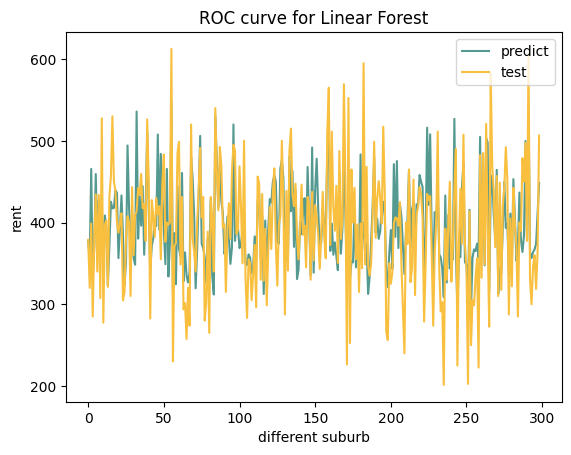

In [48]:
# draw receiver operating characteristic curve
plt.figure()
plt.plot(range(len(y_pred_lr)),y_pred_lr,'#559a90',label="predict")
plt.plot(range(len(y_pred_lr)),y_test,'#f9bf3e',label="test")
plt.legend(loc="upper right")
plt.xlabel("different suburb")
plt.ylabel('rent')
plt.title('ROC curve for Linear Forest')
plt.savefig('../plots/ROC curve for Linear Forest.png')
plt.show()

In [49]:
# evaluate the linear regression
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lr))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_lr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)))

Mean Absolute Error: 41.91224170109746
Mean Squared Error: 2905.013897403911
Root Mean Squared Error: 53.89818083575651


## Random Forest

In [50]:
# random forest regression
regressor = RandomForestRegressor(n_estimators=40, bootstrap = True, max_depth = 20, min_samples_leaf = 1, min_samples_split = 10, random_state=60)
regressor.fit(X_train, y_train)
y_pred_rf = regressor.predict(X_test)
random_forest_error=y_pred_rf-y_test

### Hyperparameter Tuning

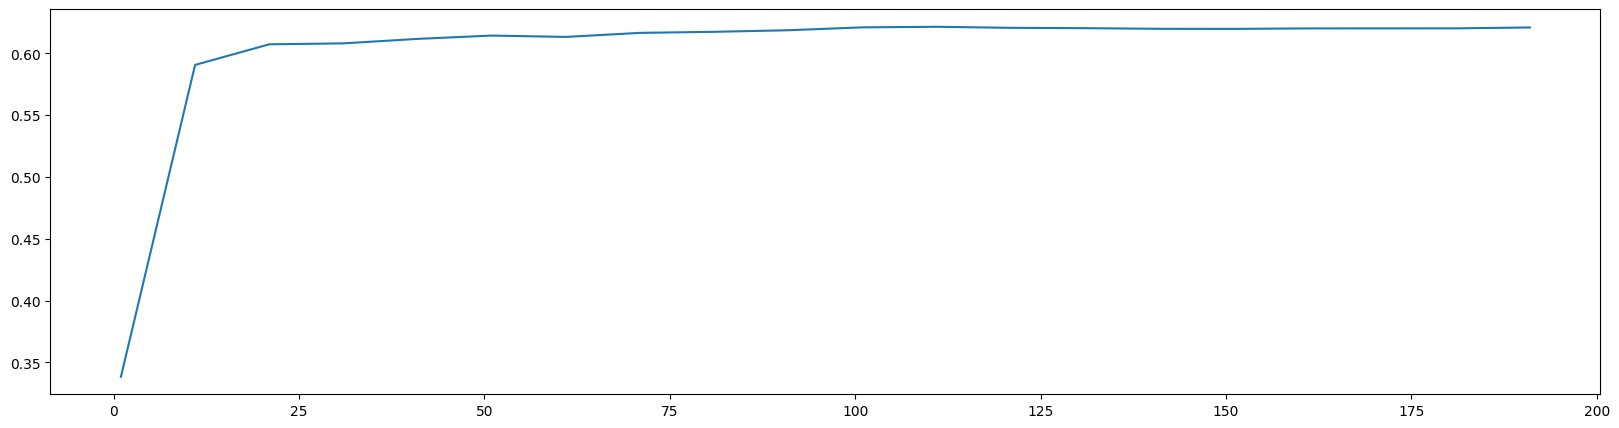

In [51]:
# choose n_estimators from plot
scorel = []
for i in range(0,200,10):
    rfc = RandomForestRegressor(n_estimators=i+1,
                                 n_jobs=-1,
                                 random_state=90)
    score = cross_val_score(rfc,X_train,y_train,cv=5).mean()
    scorel.append(score)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()

In [ ]:
# use GridSearchCV to choose other important hyperparameters
param_grid = [
    {'bootstrap': [True],
     'max_depth': [10, 20, 30, None],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [30,40,50,60]},
    ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'bootstrap': [True], 'max_depth': [10, 20, 30, None],
                          'min_samples_leaf': [1, 2, 4],
                          'min_samples_split': [2, 5, 10],
                          'n_estimators': [30, 40, 50, 60]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_ 

{'bootstrap': True,
 'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 40}

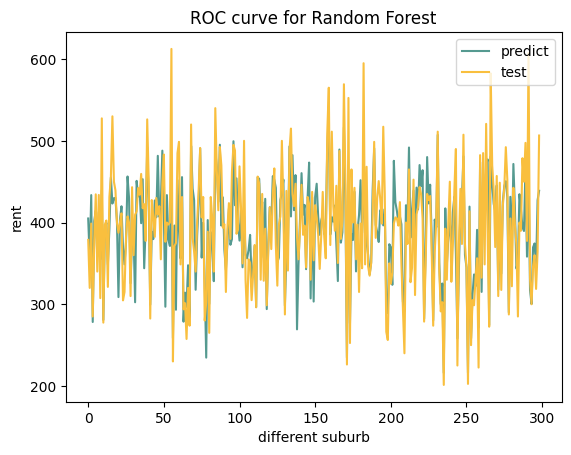

In [52]:
# draw receiver operating characteristic curve
plt.figure()
plt.plot(range(len(y_pred_rf)),y_pred_rf,'#559a90',label="predict")
plt.plot(range(len(y_pred_rf)),y_test,'#f9bf3e',label="test")
plt.legend(loc="upper right")
plt.xlabel("different suburb")
plt.ylabel('rent')
plt.title('ROC curve for Random Forest')
plt.savefig('../plots/ROC curve for Random Forest.png')
plt.show()


In [53]:
# evaluate random forest
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))

Mean Absolute Error: 32.78373503687157
Mean Squared Error: 1939.2258904197674
Root Mean Squared Error: 44.0366425879604


# Prediction

In [54]:
result = {'postcode': pt.iloc[332:498].index, '2025_pre': regressor.predict(pt_25)}
df_25 = DataFrame(result).reset_index()
df_25.head()

/home/ads/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


,index,postcode,2025_pre
0,0,3206.0,485.604772
1,1,3206.0,485.604772
2,2,3143.0,564.013904
3,3,3054.0,513.442287
4,4,3053.0,352.298823


In [55]:
df_22 = merge.drop(merge.columns[1:9], axis=1)
df_22 = df_22.drop(df_22.columns[2:], axis=1).reset_index()
df_22

,index,postcode,2022
0,0,3206.0,510.0
1,1,3206.0,510.0
2,3,3143.0,440.0
3,4,3054.0,587.5
4,5,3053.0,314.5
...,...,...,...
161,210,3844.0,370.0
162,211,3677.0,375.0
163,212,3820.0,400.0
164,213,3280.0,400.0


In [56]:
# get the rate 
df_25['2025_22_rate'] = (df_25['2025_pre'] - df_22['2022'])/df_22['2022']
df_25.head()

,index,postcode,2025_pre,2025_22_rate
0,0,3206.0,485.604772,-0.047834
1,1,3206.0,485.604772,-0.047834
2,2,3143.0,564.013904,0.281850
3,3,3054.0,513.442287,-0.126056
4,4,3053.0,352.298823,0.120187


In [57]:
sub = merge.drop(merge.columns[1:28], axis=1).reset_index(drop = True).reset_index()


In [58]:
rate_25 = pd.merge(df_25, sub, how = 'left', on = ['index','postcode'])
rate_25 = rate_25.drop(rate_25.columns[0], axis=1)
rate_25['postcode'] = rate_25['postcode'].astype(int)

In [59]:
# get top 10 suburbs with the highest rate
top10_rate_25 = rate_25.sort_values(by='2025_22_rate',ascending=False).head(10)
top10_rate_25.to_csv('../data/curated/top10_suburb.csv')
top10_rate_25


,postcode,2025_pre,2025_22_rate,suburb
152,3300,490.420210,0.582001,Hamilton
5,3052,440.549392,0.400793,Parkville
11,3184,579.671729,0.380171,Elwood
17,3181,553.678965,0.367109,Prahran
18,3181,553.678965,0.367109,Windsor
137,3357,498.962350,0.367020,Buninyong
156,3840,386.101054,0.354741,Morwell
109,3134,563.514800,0.341702,Ringwood
54,3194,584.959142,0.314515,Mentone
26,3124,596.418301,0.282620,Camberwell


# geographic visualization

In [60]:
shapes = shapefile.Reader("../data/raw/SAL_2021_AUST_GDA2020.shp").shapes()

In [61]:
suburb_shp = gpd.read_file("../data/raw/SAL_2021_AUST_GDA2020.shp")
suburb_shp[suburb_shp['STE_NAME21'] == 'Victoria']

,SAL_CODE21,SAL_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,SHAPE_Leng,SHAPE_Area,geometry
4544,20001,Abbeyard,2,Victoria,AUS,Australia,327.5008,http://linked.data.gov.au/dataset/asgsed3/SAL/...,1.207678,0.033162,"POLYGON ((146.89824 -37.04602, 146.89947 -37.0..."
4545,20002,Abbotsford (Vic.),2,Victoria,AUS,Australia,1.7405,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.092990,0.000178,"POLYGON ((145.00195 -37.79665, 145.00190 -37.7..."
4546,20003,Aberfeldie,2,Victoria,AUS,Australia,1.5515,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.059374,0.000159,"POLYGON ((144.89576 -37.76514, 144.89547 -37.7..."
4547,20004,Aberfeldy,2,Victoria,AUS,Australia,10.8319,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.183199,0.001107,"POLYGON ((146.38814 -37.72232, 146.38808 -37.7..."
4548,20005,Acheron,2,Victoria,AUS,Australia,72.6602,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.514040,0.007381,"POLYGON ((145.76731 -37.25433, 145.76757 -37.2..."
...,...,...,...,...,...,...,...,...,...,...,...
7485,22942,Yuulong,2,Victoria,AUS,Australia,52.1657,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.447416,0.005404,"POLYGON ((143.32185 -38.68969, 143.32203 -38.6..."
7486,22943,Zeerust,2,Victoria,AUS,Australia,18.0294,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.211342,0.001808,"POLYGON ((145.40454 -36.25294, 145.40479 -36.2..."
7487,22944,Zumsteins,2,Victoria,AUS,Australia,256.5582,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.810459,0.026011,"POLYGON ((142.48512 -37.15733, 142.48443 -37.1..."
7488,29494,No usual address (Vic.),2,Victoria,AUS,Australia,0.0000,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.000000,0.000000,None


In [62]:
vic_suburb = suburb_shp[suburb_shp['STE_NAME21'] == 'Victoria']
vic_suburb = vic_suburb.rename(columns={'SAL_NAME21':'suburb'})
vic_suburb = vic_suburb.drop(list(vic_suburb.columns)[0], axis=1)
vic_suburb = vic_suburb.drop(list(vic_suburb.columns)[1:9], axis=1)
vic_suburb = vic_suburb.reset_index()
vic_suburb

,index,suburb,geometry
0,4544,Abbeyard,"POLYGON ((146.89824 -37.04602, 146.89947 -37.0..."
1,4545,Abbotsford (Vic.),"POLYGON ((145.00195 -37.79665, 145.00190 -37.7..."
2,4546,Aberfeldie,"POLYGON ((144.89576 -37.76514, 144.89547 -37.7..."
3,4547,Aberfeldy,"POLYGON ((146.38814 -37.72232, 146.38808 -37.7..."
4,4548,Acheron,"POLYGON ((145.76731 -37.25433, 145.76757 -37.2..."
...,...,...,...
2941,7485,Yuulong,"POLYGON ((143.32185 -38.68969, 143.32203 -38.6..."
2942,7486,Zeerust,"POLYGON ((145.40454 -36.25294, 145.40479 -36.2..."
2943,7487,Zumsteins,"POLYGON ((142.48512 -37.15733, 142.48443 -37.1..."
2944,7488,No usual address (Vic.),None


In [63]:
# find the geometry for some suburbs from google
top10_rate_25 = top10_rate_25.reset_index(drop=True)
top10_rate_25.loc[0, 'suburb'] = 'Hamilton (Vic.)'
top10_rate_25.loc[1, 'suburb'] = 'Parkville (Vic.)'
top10_rate_25.loc[4, 'suburb'] = 'Windsor (Vic.)'
top10_rate_25.loc[7, 'suburb'] = 'Ringwood (Vic.)'
top10_rate_25.loc[9, 'suburb'] = 'Camberwell (Vic.)'
top10_rate_25

,postcode,2025_pre,2025_22_rate,suburb
0,3300,490.420210,0.582001,Hamilton (Vic.)
1,3052,440.549392,0.400793,Parkville (Vic.)
2,3184,579.671729,0.380171,Elwood
3,3181,553.678965,0.367109,Prahran
4,3181,553.678965,0.367109,Windsor (Vic.)
5,3357,498.962350,0.367020,Buninyong
6,3840,386.101054,0.354741,Morwell
7,3134,563.514800,0.341702,Ringwood (Vic.)
8,3194,584.959142,0.314515,Mentone
9,3124,596.418301,0.282620,Camberwell (Vic.)


In [64]:
draw = pd.merge(vic_suburb, top10_rate_25,  how= 'right', on='suburb')
draw

,index,suburb,geometry,postcode,2025_pre,2025_22_rate
0,5672,Hamilton (Vic.),"POLYGON ((142.07560 -37.78526, 142.07558 -37.7...",3300,490.420210,0.582001
1,6581,Parkville (Vic.),"POLYGON ((144.95955 -37.78348, 144.95940 -37.7...",3052,440.549392,0.400793
2,5410,Elwood,"POLYGON ((144.98435 -37.87244, 144.98485 -37.8...",3184,579.671729,0.380171
3,6661,Prahran,"POLYGON ((145.00158 -37.85781, 145.00160 -37.8...",3181,553.678965,0.367109
4,7348,Windsor (Vic.),"POLYGON ((144.99338 -37.85184, 144.99420 -37.8...",3181,553.678965,0.367109
5,4952,Buninyong,"POLYGON ((143.88621 -37.64250, 143.88619 -37.6...",3357,498.962350,0.367020
6,6312,Morwell,"POLYGON ((146.42527 -38.24449, 146.42454 -38.2...",3840,386.101054,0.354741
7,6717,Ringwood (Vic.),"POLYGON ((145.23743 -37.82288, 145.23736 -37.8...",3134,563.514800,0.341702
8,6191,Mentone,"POLYGON ((145.07991 -37.98299, 145.07961 -37.9...",3194,584.959142,0.314515
9,4996,Camberwell (Vic.),"POLYGON ((145.09636 -37.84621, 145.09631 -37.8...",3124,596.418301,0.282620


In [65]:
geoJSON = draw[['geometry']].to_json()

In [66]:
m = folium.Map(location=(-37.74582838114469, 142.0176194718262), tiles="Stamen Terrain", zoom_start=10)
# refer to the folium documentations on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth',
).add_to(m)
m

In [67]:
def get_centerpoint(lis):
    """
    program: calculate center point of suburb
    paras: longtitude, latutude
    """
    area = 0.0
    latitude,longtitude = 0.0,0.0
 
    a = len(lis)
    for i in range(a):
        lat = float(lis[i][1]) #weidu
        lng = float(lis[i][0]) #jingdu
 
        if i == 0:
            lat1 = float(lis[-1][1])
            lng1 = float(lis[-1][0])
 
        else:
            lat1 = float(lis[i-1][1])
            lng1 = float(lis[i-1][0])
 
        fg = (lat*lng1 - lng*lat1)/2.0
 
        area += fg
        latitude += fg*(lat+lat1)/3.0
        longtitude += fg*(lng+lng1)/3.0
 
    latitude = latitude/area
    longtitude = longtitude/area
 
    return latitude, longtitude 

In [68]:
coordinates = []
for i in draw['index'].tolist():
    coordinates.append(get_centerpoint(shapes[i].points))
coordinates

[(-37.74582838114469, 142.0176194718262),
 (-37.786753336090996, 144.95133018487266),
 (-37.88077282186206, 144.98550326009283),
 (-37.85177289331336, 145.00039954355438),
 (-37.854535971620805, 144.99267667882972),
 (-37.65190677851944, 143.8972756692839),
 (-38.22756659114581, 146.41451510517106),
 (-37.811426294868625, 145.23346050007007),
 (-37.981573702484354, 145.06941347894409),
 (-37.83835698780556, 145.0736777637629)]

In [69]:
draw['center'] = coordinates
draw

,index,suburb,geometry,postcode,2025_pre,2025_22_rate,center
0,5672,Hamilton (Vic.),"POLYGON ((142.07560 -37.78526, 142.07558 -37.7...",3300,490.420210,0.582001,"(-37.74582838114469, 142.0176194718262)"
1,6581,Parkville (Vic.),"POLYGON ((144.95955 -37.78348, 144.95940 -37.7...",3052,440.549392,0.400793,"(-37.786753336090996, 144.95133018487266)"
2,5410,Elwood,"POLYGON ((144.98435 -37.87244, 144.98485 -37.8...",3184,579.671729,0.380171,"(-37.88077282186206, 144.98550326009283)"
3,6661,Prahran,"POLYGON ((145.00158 -37.85781, 145.00160 -37.8...",3181,553.678965,0.367109,"(-37.85177289331336, 145.00039954355438)"
4,7348,Windsor (Vic.),"POLYGON ((144.99338 -37.85184, 144.99420 -37.8...",3181,553.678965,0.367109,"(-37.854535971620805, 144.99267667882972)"
5,4952,Buninyong,"POLYGON ((143.88621 -37.64250, 143.88619 -37.6...",3357,498.962350,0.367020,"(-37.65190677851944, 143.8972756692839)"
6,6312,Morwell,"POLYGON ((146.42527 -38.24449, 146.42454 -38.2...",3840,386.101054,0.354741,"(-38.22756659114581, 146.41451510517106)"
7,6717,Ringwood (Vic.),"POLYGON ((145.23743 -37.82288, 145.23736 -37.8...",3134,563.514800,0.341702,"(-37.811426294868625, 145.23346050007007)"
8,6191,Mentone,"POLYGON ((145.07991 -37.98299, 145.07961 -37.9...",3194,584.959142,0.314515,"(-37.981573702484354, 145.06941347894409)"
9,4996,Camberwell (Vic.),"POLYGON ((145.09636 -37.84621, 145.09631 -37.8...",3124,596.418301,0.282620,"(-37.83835698780556, 145.0736777637629)"


In [70]:
for i in range(len(draw)):
    zone_name =  draw['suburb'].tolist()[i]
    coord = draw['center'].tolist()[i]
    m.add_child(
        folium.Marker(location=coord, popup=zone_name)
    )
m.save('../plots/top_10 suburbs.html')
m